# Predicting the team that will win UEFA EURO 2020

**Credits**

Dataset we used came from here from Mart Jürisoo: https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017

We don't claim the full credits for this project a lot of credit goes to Nathan Lauga and his kernel: https://www.kaggle.com/nathanlauga/which-team-will-win-the-2018-fifa-world-cup

**Reading in data and importing libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

data = pd.read_csv("results.csv")
data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
41841,2020-11-18,Kosovo,Moldova,1,0,UEFA Nations League,Pristina,Kosovo,False
41842,2020-11-18,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
41843,2020-11-18,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False
41844,2020-11-18,Kazakhstan,Lithuania,1,2,UEFA Nations League,Almaty,Kazakhstan,False


In [2]:
tournament = data['tournament'].value_counts()
tournaments = []
for index1, value in tournament.iteritems():
  tournaments.append(index1)
print(tournaments)
datacopy = data.copy()
for i in tournaments:
  if "FIFA" in i or "UEFA" in i:
    continue
  else:
    datacopy = datacopy[datacopy.tournament != i]

datacopy

['Friendly', 'FIFA World Cup qualification', 'UEFA Euro qualification', 'African Cup of Nations qualification', 'FIFA World Cup', 'Copa América', 'AFC Asian Cup qualification', 'African Cup of Nations', 'CECAFA Cup', 'CFU Caribbean Cup qualification', 'British Championship', 'Merdeka Tournament', 'Gulf Cup', 'AFC Asian Cup', 'Island Games', 'Gold Cup', 'UEFA Nations League', 'AFF Championship', 'COSAFA Cup', 'UEFA Euro', 'Nordic Championship', 'African Nations Championship', 'CFU Caribbean Cup', 'Amílcar Cabral Cup', "King's Cup", 'South Pacific Games', 'UNCAF Cup', 'Korea Cup', 'Confederations Cup', 'SAFF Cup', 'International Cup', 'CCCF Championship', 'EAFF Championship', 'UAFA Cup', 'CONCACAF Nations League', 'Oceania Nations Cup', 'CONIFA World Football Cup', 'Windward Islands Tournament', 'AFC Challenge Cup', 'WAFF Championship', 'AFC Challenge Cup qualification', 'Nehru Cup', 'Balkan Cup', 'Baltic Cup', 'Indonesia Tournament', 'Oceania Nations Cup qualification', 'Cyprus Internat

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
1304,1930-07-13,Belgium,United States,0,3,FIFA World Cup,Montevideo,Uruguay,True
1305,1930-07-13,France,Mexico,4,1,FIFA World Cup,Montevideo,Uruguay,True
1306,1930-07-14,Brazil,Yugoslavia,1,2,FIFA World Cup,Montevideo,Uruguay,True
1307,1930-07-14,Peru,Romania,1,3,FIFA World Cup,Montevideo,Uruguay,True
1308,1930-07-15,Argentina,France,1,0,FIFA World Cup,Montevideo,Uruguay,True
...,...,...,...,...,...,...,...,...,...
41840,2020-11-18,Georgia,Estonia,0,0,UEFA Nations League,Tbilisi,Georgia,False
41841,2020-11-18,Kosovo,Moldova,1,0,UEFA Nations League,Pristina,Kosovo,False
41842,2020-11-18,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
41843,2020-11-18,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False


**Diffrent** data possibilities taking into account the time:

In [3]:
# 22448 is first index where > 2000, or 19987 when remove some of the tournaments
dataFrom2000 = datacopy.copy()
dataFrom2000 = dataFrom2000.astype({'date': 'datetime64[ns]'})

date1 =  dataFrom2000['date'].value_counts()
for index, value in date1.iteritems():
    if index.year >= 2000:
        continue
    else:
        dataFrom2000 = dataFrom2000[dataFrom2000.date != index]

#dataFrom2000 = dataFrom2000.drop(dataFrom2000.index[:22448]) 
#dataFrom2000.head()
dataFrom2000 = dataFrom2000.reset_index(drop=True)
dataFrom2000


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2000-03-04,Honduras,Nicaragua,3,0,FIFA World Cup qualification,San Pedro Sula,Honduras,False
1,2000-03-04,Trinidad and Tobago,Curaçao,5,0,FIFA World Cup qualification,Macoya,Trinidad and Tobago,False
2,2000-03-05,Anguilla,Bahamas,1,3,FIFA World Cup qualification,The Valley,Anguilla,False
3,2000-03-05,Barbados,Grenada,2,2,FIFA World Cup qualification,Bridgetown,Barbados,False
4,2000-03-05,British Virgin Islands,Bermuda,1,5,FIFA World Cup qualification,Road Town,British Virgin Islands,False
...,...,...,...,...,...,...,...,...,...
6198,2020-11-18,Georgia,Estonia,0,0,UEFA Nations League,Tbilisi,Georgia,False
6199,2020-11-18,Kosovo,Moldova,1,0,UEFA Nations League,Pristina,Kosovo,False
6200,2020-11-18,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
6201,2020-11-18,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False


In [4]:


dataFrom2010 = datacopy.copy()
dataFrom2010 = dataFrom2010.astype({'date': 'datetime64[ns]'})

date2 =  dataFrom2010['date'].value_counts()
for index, value in date2.iteritems():
    if index.year >= 2010:
        continue
    else:
        dataFrom2010 = dataFrom2010[dataFrom2010.date != index]


dataFrom2010 = dataFrom2010.reset_index(drop=True)
dataFrom2010


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2010-06-11,South Africa,Mexico,1,1,FIFA World Cup,Johannesburg,South Africa,False
1,2010-06-11,Uruguay,France,0,0,FIFA World Cup,Cape Town,South Africa,True
2,2010-06-12,Argentina,Nigeria,1,0,FIFA World Cup,Johannesburg,South Africa,True
3,2010-06-12,England,United States,1,1,FIFA World Cup,Rustenburg,South Africa,True
4,2010-06-12,South Korea,Greece,2,0,FIFA World Cup,Port Elizabeth,South Africa,True
...,...,...,...,...,...,...,...,...,...
3063,2020-11-18,Georgia,Estonia,0,0,UEFA Nations League,Tbilisi,Georgia,False
3064,2020-11-18,Kosovo,Moldova,1,0,UEFA Nations League,Pristina,Kosovo,False
3065,2020-11-18,Greece,Slovenia,0,0,UEFA Nations League,Athens,Greece,False
3066,2020-11-18,Albania,Belarus,3,2,UEFA Nations League,Tirana,Albania,False


**Looking how many UEFA Euro qualification and UEFA Euro main matches took place.**

In [5]:
tournament = data['tournament'].value_counts()

for index, value in tournament.iteritems():
  if "UEFA" in index:
    print("Tournament: " + index + " Count: " + str(value))

Tournament: UEFA Euro qualification Count: 2582
Tournament: UEFA Nations League Count: 304
Tournament: UEFA Euro Count: 286


In [6]:
def weightOfYear(yearof):
    return 1 / (2021 - yearof.year)
def chooseDataToUse(matches):
  
  weights = [weightOfYear(x) for x in matches['date']]
  matches['weight'] = weights

  matches_model_data = pd.concat([matches[['home_team','away_team','home_score','weight']].rename(
              columns={'home_team':'team', 'away_team':'opponent','home_score':'goals'}),
            matches[['away_team','home_team','away_score','weight']].rename(
              columns={'away_team':'team', 'home_team':'opponent','away_score':'goals'})])
  return matches_model_data

Training the model with data.

In [7]:
###### Choose which dataset to take options are: dataFrom2000, dataFrom2010, and just data.
dataFrom2000 = dataFrom2000.astype({'date':'datetime64[ns]'})
gamemodel = chooseDataToUse(dataFrom2000)

poisson_model = smf.glm(formula="goals ~ team + opponent", data=gamemodel,
                        family=sm.families.Poisson(), freq_weights=gamemodel['weight'].values).fit()


In [8]:
def getMatchProbability(model, team1, team2, max_goals=10):
    # Get the average goal for each team
    team1MeanGoals = model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
    team2MeanGoals = model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]
    print(team1MeanGoals)
    teamPrediction = []
    for teamAverage in [team1MeanGoals, team2MeanGoals]:
        temp = []
        for i in range(0, max_goals + 1):
            temp.append(poisson.pmf(i, teamAverage))
        teamPrediction.append(temp)

    teamPrediction = np.array(teamPrediction)
    teamP1 = teamPrediction[0]
    teamP2 = teamPrediction[1]

    match = np.outer(teamP1, teamP2)

  
    team1_matrix = np.tril(match, -1)
    team1_wins = np.sum(team1_matrix)

    draw_matrix = np.diag(match)
    draw = np.sum(draw_matrix)

    team2_matrix = np.triu(match, 1)
    team2_wins = np.sum(team2_matrix)
    resultProbability = np.array([team1_wins, draw, team2_wins])

    resultProbability = resultProbability / resultProbability.sum(axis=0, keepdims=1)

    teamP1 = teamP1 / teamP1.sum(axis=0, keepdims=1)
    teamP2 = teamP2 / teamP2.sum(axis=0, keepdims=1)

    # Returns the probability for team1 win, draw and team2 win and probabilities for the score
    return resultProbability, [teamP1, teamP2]



In [9]:
import operator
def get_match_result(model, team1, team2, elimination=False, max_draw=50, max_goals=10):
    # Get the probability
    proba, scoreprobability = getMatchProbability(model, team1, team2, max_goals)
    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results1 = {team1: 0, 'draw': 0, team2: 0}
    for i in range(0, max_draw):
        x = np.random.choice([team1, 'draw', team2], p=proba)
        results1[x] = results1[x] + 1
    sortedDict = dict(sorted(results1.items(), key=operator.itemgetter(1), reverse=True))

    maxValue1 = ""
    secondBiggest = ""
    m = 0
    for c in sortedDict.keys():
        if m == 0:
            maxValue1 = c
        if m == 1:
            secondBiggest = c
        m += 1

    result = ""
    if elimination and maxValue1 != 'draw':
        result = maxValue1
    elif not elimination:
        result = maxValue1
    else:
        result = secondBiggest


    if (result != 'draw'):
        # winner, loser = (0,1) if result == team1 else (1,0)
        if result == team1:
            # 1st array is team 1
            winner, loser = (0, 1)
        else:
            # 2nd array is team 2
            winner, loser = (1, 0)

        # because 0 goals isn't an option anymore
        scoreprobability[winner] = scoreprobability[winner][1:] / scoreprobability[winner][1:].sum(axis=0, keepdims=1)

        winner_score_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}

        for i in range(0, max_draw):
            x = np.random.choice(range(1, max_goals + 1), p=scoreprobability[winner])
            winner_score_dict[x] = winner_score_dict[x] + 1

  

        winner_score = max(winner_score_dict.items(), key=operator.itemgetter(1))[0]

        # Until winner score because loser score can't be higher can also be 0
        scoreprobability[loser] = scoreprobability[loser][:winner_score] / scoreprobability[loser][:winner_score].sum(axis=0,
                                                                                                          keepdims=1)

        loser_score_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}

        for i in range(0, max_draw):
            x = np.random.choice(range(0, winner_score), p=scoreprobability[loser])
            loser_score_dict[x] = loser_score_dict[x] +1

        loser_score = max(loser_score_dict.items(), key=operator.itemgetter(1))[0]

        
        score = [winner_score, loser_score]
    else:
        score = []

        for i in range(0, max_draw):
            x = np.random.choice(range(0, max_goals + 1), p=scoreprobability[0])
            score.append(x)
            score.append(x)


    if result != 'draw':
        if result == team1:
            loser = team2
        else:
            loser = team1
    else:
        loser = 'draw'
    return result, loser, score



Group stage, draw is allowed, draw = 1 point, win = 3 points, lose = 0 points

In [10]:
groupA = ['Turkey', 'Italy', 'Wales', 'Switzerland']
groupB = ['Denmark', 'Finland', 'Belgium', 'Russia']
groupC = ['Netherlands', 'Ukraine', 'Austria', 'North Macedonia']
groupD = ['England', 'Croatia', 'Scotland', 'Czech Republic']
groupE = ['Spain', 'Sweden', 'Poland', 'Slovakia']
groupF = ['Hungary', 'Portugal', 'France', 'Germany']

groups = [groupA, groupB, groupC, groupD, groupE, groupF]


How winners from group stage are divided into the round of 16


Round of 16

2nd in Group A vs 2nd in Group B <br>
1st in Group A 2nd in Group C

1st in Group C vs 3rd in Groups D/E or F <br>
1st in Group B vs 3rd in Groups A/D/E or F

2nd IN Group D vs 2nd in Group E <br>
1st in Group F vs 3rd in Groups A/B or C

1st in Group D vs 2nd in Group F <br>
1st in Group E vs 3rd in Groups A/B/C or D


Predictin the tournament result from the know participants of the group stage

In [11]:
def get_group_result(model, group, goals, against):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        winner, loser, score = get_match_result(model, team1, team2)
        
        
        print(winner, '-', loser,':', score)
        if winner == 'draw':
            ranking.loc[[team1, team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
            goals[team1] = goals[team1] + score[0]
            goals[team2] = goals[team2] + score[0]
            against[team1] = against[team1] + score[0]
            against[team2] = against[team2] + score[0]

        else:
            ranking.loc[winner, 'points'] += 3
            ranking.loc[winner, 'goals'] += score[0]
            ranking.loc[loser, 'goals'] += score[1]
            ranking.loc[winner, 'diff'] += score[0]-score[1]
            ranking.loc[loser, 'diff'] -= score[0]-score[1]
            goals[winner] = goals[winner] + score[0]
            goals[loser] = goals[loser] + score[1]
            against[winner] = against[winner] + score[1]
            against[loser] = against[loser] + score[0]
            
    return ranking.sort_values(by=['points','diff','goals'], ascending=False)



# Choose the 3rd winner from group stage if there are 3 options
def choose3rd(nowtolist, option1, option2, option3):
  toReturn = []
  options = [option1, option2, option3]
  for option in options:
    for i in nowtolist:
      if i[4] == option:
        temp = i.copy()
        nowtolist.remove(i)
        return temp[0]


# Choose the 3rd winner from group stage if there are 4 options
def choose3rdv2(nowtolist, option1, option2, option3, option4):
  toReturn = []
  options = [option1, option2, option3, option4]
  for option in options:
    for i in nowtolist:
      if i[4] == option:
        temp = i.copy()
        nowtolist.remove(i)
        return temp[0]


# This is dictionary to store how many tournament wins every team got.
dictToStoreResults = {'Turkey' : 0, 'Italy' : 0, 'Wales' : 0, 'Switzerland' : 0, 'Denmark' : 0, 'Finland' : 0, 'Belgium' : 0, 'Russia' : 0, 'Netherlands' : 0, 'Ukraine' : 0, 'Austria' : 0, 'North Macedonia' : 0, 'England'  : 0, 'Croatia'  : 0, 'Scotland' : 0, 'Czech Republic' : 0, 'Spain' : 0, 'Sweden' : 0, 'Poland' : 0, 'Slovakia' : 0, 'Hungary' : 0, 'Portugal' : 0, 'France' : 0, 'Germany' : 0}
# This is dictionary to store how many goals every team scored.
dictToStoreGoals = {'Turkey' : 0, 'Italy' : 0, 'Wales' : 0, 'Switzerland' : 0, 'Denmark' : 0, 'Finland' : 0, 'Belgium' : 0, 'Russia' : 0, 'Netherlands' : 0, 'Ukraine' : 0, 'Austria' : 0, 'North Macedonia' : 0, 'England'  : 0, 'Croatia'  : 0, 'Scotland' : 0, 'Czech Republic' : 0, 'Spain' : 0, 'Sweden' : 0, 'Poland' : 0, 'Slovakia' : 0, 'Hungary' : 0, 'Portugal' : 0, 'France' : 0, 'Germany' : 0}
# This is dictionary to store how many goals every team conceded.
dictToStoreAgainstGoals = {'Turkey' : 0, 'Italy' : 0, 'Wales' : 0, 'Switzerland' : 0, 'Denmark' : 0, 'Finland' : 0, 'Belgium' : 0, 'Russia' : 0, 'Netherlands' : 0, 'Ukraine' : 0, 'Austria' : 0, 'North Macedonia' : 0, 'England'  : 0, 'Croatia'  : 0, 'Scotland' : 0, 'Czech Republic' : 0, 'Spain' : 0, 'Sweden' : 0, 'Poland' : 0, 'Slovakia' : 0, 'Hungary' : 0, 'Portugal' : 0, 'France' : 0, 'Germany' : 0}


##### Here you can change the number of simulations done


for i in range(1000):
  groups_ranking = []
  for group in groups:
      groups_ranking.append(get_group_result(poisson_model, group, dictToStoreGoals, dictToStoreAgainstGoals))



  data1 = []
  grps =['A', 'B', 'C', 'D', 'E', 'F']
  idx = 0
  for thing in groups_ranking:
    arr = thing.values.tolist().copy()
    add = [thing.index[2], arr[2][0], arr[2][1], arr[2][2], grps[idx]]
    data1.append(add)
    idx += 1

  print(data1)
  kolmandadkohad = pd.DataFrame(data1,  columns=['name', 'points', 'diff', 'goals', 'group_from'])
  kolmandadkohad = kolmandadkohad.sort_values(by=['points','goals','diff'], ascending=False)
  nowtolist = kolmandadkohad.values.tolist()
  nowtolist.pop()
  nowtolist.pop()
  print(nowtolist)






  esimene16 = []
  teine16 = []
  kolmas16 = []
  neljas16 = []
  viies16 = []
  kuues16 = []
  seitsmes16 = []
  kaheksas16 = []

  esimene16.append(groups_ranking[0].index[1])
  esimene16.append(groups_ranking[1].index[1])

  teine16.append(groups_ranking[0].index[0])
  teine16.append(groups_ranking[2].index[1])

  kolmas16.append(groups_ranking[2].index[0])
  kolmas16.append(choose3rd(nowtolist ,'E', 'F', 'D'))
  print("ALL ON KOLMAS")
  print(kolmas16)


  neljas16.append(groups_ranking[1].index[0])
  neljas16.append(choose3rdv2(nowtolist, 'E', 'F', 'A', 'D'))


  viies16.append(groups_ranking[3].index[1])
  viies16.append(groups_ranking[4].index[1])

  kuues16.append(groups_ranking[5].index[0])
  kuues16.append(choose3rd(nowtolist, 'B', 'C', 'A'))


  seitsmes16.append(groups_ranking[3].index[0])
  seitsmes16.append(groups_ranking[5].index[1])

  kaheksas16.append(groups_ranking[4].index[0])
  kaheksas16.append(choose3rdv2(nowtolist, 'B', 'C', 'A', 'D'))

  




  ############################### 16-finaalid
  final16 = [esimene16, teine16, kolmas16,neljas16,viies16, kuues16,seitsmes16, kaheksas16]
  #print("16 finaal: " + str(final16))
  final8 = []
  for game in final16:
    winner, loser, score = get_match_result(poisson_model, game[0], game[1], elimination=True)
    final8.append(winner)

    dictToStoreGoals[winner] = dictToStoreGoals[winner] + score[0]
    dictToStoreGoals[loser] = dictToStoreGoals[loser] + score[1]

    dictToStoreAgainstGoals[winner] = dictToStoreAgainstGoals[winner] + score[1]
    dictToStoreAgainstGoals[loser] = dictToStoreAgainstGoals[loser] + score[0]
    
  ############################## Quarterfinal
  esimene8 = [final8[0], final8[1]]
  teine8 = [final8[2], final8[3]]
  kolmas8 = [final8[4], final8[5]]
  neljas8 = [final8[6], final8[7]]

  quarterfinals = [esimene8, teine8, kolmas8, neljas8] 
  final4 = []
  for game in quarterfinals:
    winner, loser, score = get_match_result(poisson_model, game[0], game[1], elimination=True)
    final4.append(winner)
    dictToStoreGoals[winner] = dictToStoreGoals[winner] + score[0]
    dictToStoreGoals[loser] = dictToStoreGoals[loser] + score[1]

    dictToStoreAgainstGoals[winner] = dictToStoreAgainstGoals[winner] + score[1]
    dictToStoreAgainstGoals[loser] = dictToStoreAgainstGoals[loser] + score[0]
    

  esimene4 = [final4[0], final4[1]]
  teine4 = [final4[2],final4[3]]


  ############################ Half final
  semifinals = []
  semifinals.append(esimene4)
  semifinals.append(teine4)
  final = []
  for game in semifinals:
    winner, loser, score = get_match_result(poisson_model, game[0], game[1], elimination=True)
    final.append(winner)
    dictToStoreGoals[winner] = dictToStoreGoals[winner] + score[0]
    dictToStoreGoals[loser] = dictToStoreGoals[loser] + score[1]

    dictToStoreAgainstGoals[winner] = dictToStoreAgainstGoals[winner] + score[1]
    dictToStoreAgainstGoals[loser] = dictToStoreAgainstGoals[loser] + score[0]

  ########################## Final
  overall_winner = get_match_result(poisson_model, final[0], final[1], elimination=True)
  print(overall_winner)

  dictToStoreResults[overall_winner[0]] = dictToStoreResults[overall_winner[0]] + 1
  dictToStoreGoals[overall_winner[0]] = dictToStoreGoals[overall_winner[0]] + score[0]
  dictToStoreGoals[overall_winner[1]] = dictToStoreGoals[overall_winner[1]] + score[1]

  dictToStoreAgainstGoals[overall_winner[0]] = dictToStoreAgainstGoals[overall_winner[0]] + score[1]
  dictToStoreAgainstGoals[overall_winner[1]] = dictToStoreAgainstGoals[overall_winner[1]] + score[0]

print(dictToStoreResults)
print(dictToStoreGoals)
print(dictToStoreAgainstGoals)



Streaming output truncated to the last 5000 lines.
France - Hungary : [2, 0]
0.9936891880220409
Germany - Hungary : [2, 0]
1.0803693313718163
France - Portugal : [1, 0]
1.7481119612943798
Germany - Portugal : [1, 0]
1.5984267113012922
France - Germany : [1, 0]
[['Wales', 3, -1, 1, 'A'], ['Russia', 3, -1, 2, 'B'], ['Austria', 3, -1, 2, 'C'], ['Czech Republic', 3, -1, 2, 'D'], ['Sweden', 3, 0, 3, 'E'], ['Portugal', 3, -1, 1, 'F']]
[['Sweden', 3, 0, 3, 'E'], ['Russia', 3, -1, 2, 'B'], ['Austria', 3, -1, 2, 'C'], ['Czech Republic', 3, -1, 2, 'D']]
ALL ON KOLMAS
['Netherlands', 'Sweden']
1.1343257738112464
1.3725772204224074
1.6720418235141532
1.882608248652537
1.3640609684629117
1.8144650250209386
1.7027117133498817
2.0512679471759405
0.6905240375206237
1.3936099572272178
0.8317501874238726
1.1463853121049383
1.202554115687778
0.8683772645684567
1.0145661911471684
('Spain', 'Belgium', [1, 0])
0.5198349480039767
Italy - Turkey : [1, 0]
0.8223439457920788
draw - draw : [0, 0, 1, 1, 1, 1, 1, 

Bar chart to show how many goals certain country scored and conceded

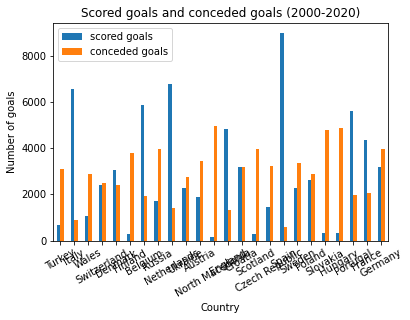

In [12]:

goals = list(dictToStoreGoals.values())
goalsAgainst = list(dictToStoreAgainstGoals.values())
EM_wins = list(dictToStoreResults.values())
index = list(dictToStoreGoals.keys())
df = pd.DataFrame({'scored goals': goals,
                   'conceded goals': goalsAgainst}, index=index) # Siia võib lisada selle, et kes kui palju turnasi võitis ka
ax = df.plot.bar(rot=0)
plt.xticks(rotation=30, horizontalalignment="center")

#plt.title("Scored goals and conceded goals (2010-2020)")
plt.title("Scored goals and conceded goals (2000-2020)")
plt.xlabel("Country")
plt.ylabel("Number of goals")
plt.rcParams["figure.figsize"] = [17, 8]



In [13]:


print("Average goals per game: ", sum(goals)/(51 * 1000))

Average goals per game:  1.3773921568627452


Bar chart too see who won and how many times

Text(0, 0.5, 'wins')

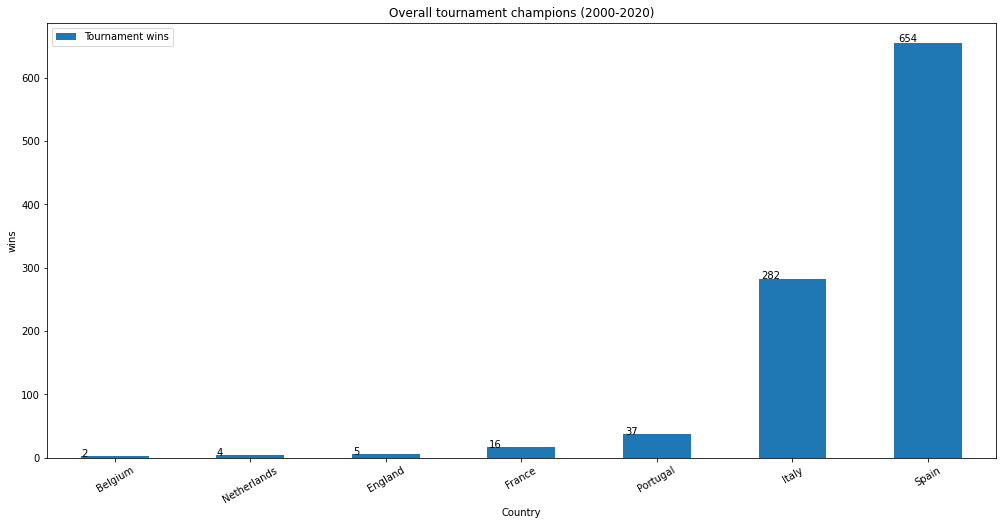

In [14]:
onlyWinners = {}
for i in dictToStoreResults:
  if dictToStoreResults[i] != 0:
    onlyWinners[i] = dictToStoreResults[i]

index2 = list(onlyWinners.keys())
results2 = list(onlyWinners.values())


df = pd.DataFrame({'Tournament wins': results2}, index=index2) 
df.sort_values('Tournament wins',inplace=True)
ax = df.plot.bar(rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), )
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Overall tournament champions (2000-2020)")
#plt.title("Overall tournament champions (2010-2020)")
plt.xlabel("Country")
plt.ylabel("wins")